# 이미지 캡셔닝 Image Captioning
-----
- 이미지를 설명하는 텍스트를 반환
- COLAB 사용해서 밑의 코딩들은 코랩 중심으로 기술
- 참조
  - 데이터 : https://www.kaggle.com/code/shadabhussain/automated-image-captioning-flickr8/data
  - 정보 : https://jiho-ml.com/weekly-nlp-24/
  - 논문 : https://arxiv.org/pdf/1411.4555.pdf
  - 한글버젼 : https://www.dinolabs.ai/295
  - 영어버젼 : https://www.kaggle.com/code/programminghut/imagecaptioning/notebook#MODEL
  - 사진 및 논문해설 : https://www.youtube.com/watch?v=yfsFW-mfOEY

# - **기계 번역 작업에서의 인코더를 CNN으로 대체하여 이미지 캡션 생성**

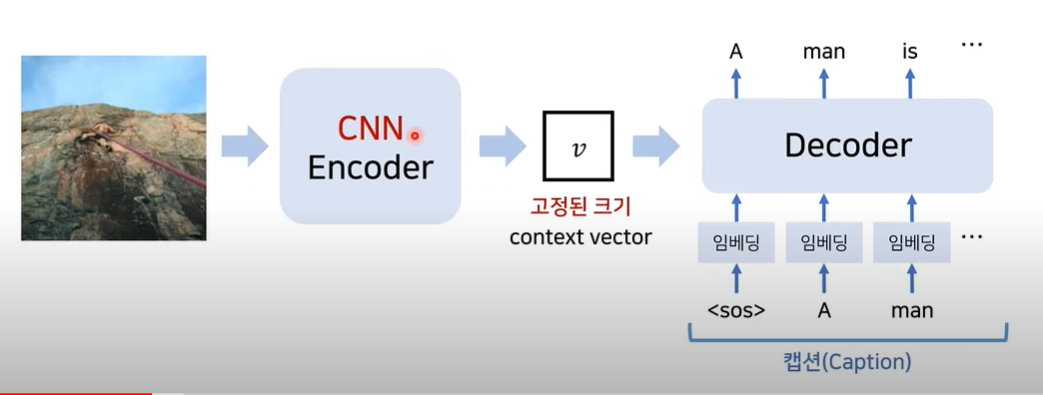

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# GPU에 메모리 할당
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [4]:
cd /content/drive/MyDrive/Colab Notebooks/Kaggle/

/content/drive/MyDrive/Colab Notebooks/Kaggle


## ㄱ. 데이터 로딩

In [5]:
import numpy as np
import pandas as pd
import cv2  # 이미지 처리
import os
from glob import glob  

In [6]:
images_path = './Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

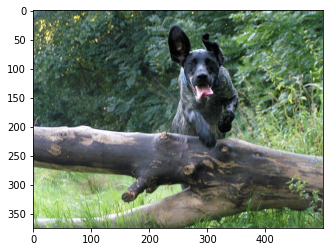

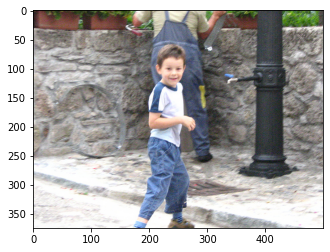

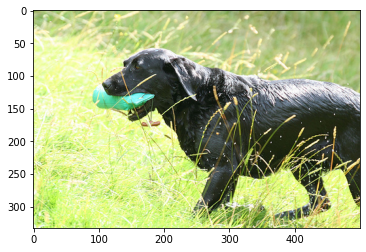

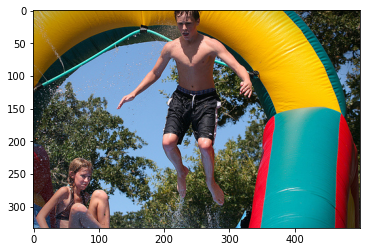

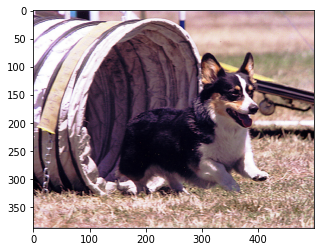

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
  plt.figure()
  img = cv2.imread(images[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # color 사진을 cv2에서는 BGR로 저장하는데, matplotlib에서는 RGB를 쓰기 때문에 BGR -> RGB 전환
  plt.imshow(img)

## ㄴ. 사용할 모델 로딩 ResNet50
- ResNet50 모델 들고올때, 마지막 부분의 Dense 레이어는 제거
- 인코딩 부분인 ResNet50 수행

In [7]:
from tensorflow.keras.applications import ResNet50
incept_md = ResNet50(include_top=True) # whether to include the fully-connected layer at the top of the network.

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
incept_md.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

###  ResNet50 모델 들고올때, 마지막 부분의 Dense 레이어는 제거

In [8]:
# ResNet50 모델 들고올때, 마지막 부분의 Dense 레이어는 제거
from tensorflow.keras import Model
outputs = incept_md.layers[-2].output
mde = Model(inputs=incept_md.input, outputs=outputs)
mde.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
images[0].split('/')[-1]


'1015584366_dfcec3c85a.jpg'

### 인코딩 부분인 ResNet50 수행 
- 리턴값 : dict 형태로 key는 이미지 파일 명 (ex. 1015584366_dfcec3c85a.jpg) 이고 value는 ResNet50의 예측값인 (2048,) 길이의 벡터

In [9]:
# 인코딩 부분인 ResNet50 수행 -> 리턴: 
img_feature = {}
count = 0
for i in images:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))  # 이미지 크기 (224,224)로 크기조절

  img = img.reshape(1,224,224,3) # 이미지 데이터 (224,224,3)
  pred = mde.predict(img).reshape(2048,) # mde 모델의 출력 벡터의 차원은 (1,2048) -> (2048,)

  img_name = i.split('/')[-1] # 이미지 이름 지정
  img_feature[img_name] = pred
  count += 1

  if count > 1499:    # 이미지 개수 1500개 제한
    break
  elif count % 50 == 0:
    print(count)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [ ]:
len(img_feature)

1500

## ㄷ. 텍스트 전처리
- 캡션 파일은 ./Flickr_Data/Flickr_TextData/Flickr8k.token.txt 참고
- captions_dict 딕셔너리에 key로는 파일명, value로는 캡션 5개를 list형태로 들고온다.

In [10]:
caption_path = './Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')
len(captions)

40461

In [ ]:
# caption은 다음과 같은 형태로 들어가 있다.-> \t 기준으로 자르면 된다.
# 다른 캡션 데이터에는 적용안될 부분
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [11]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in img_feature:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [12]:
len(captions_dict)

1500

## ㄹ. 캡션 - 이미지 예시

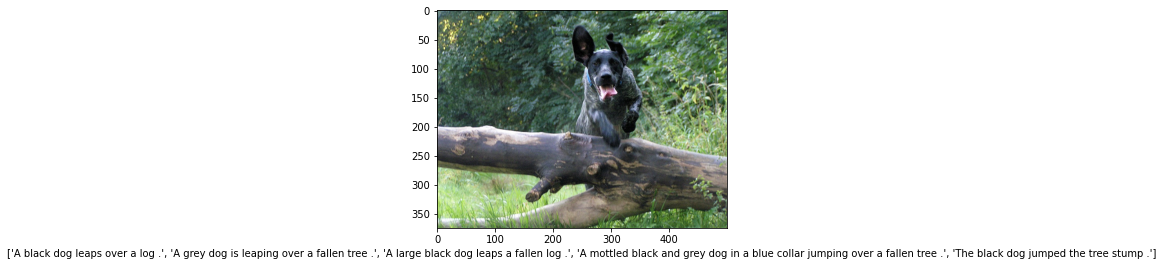

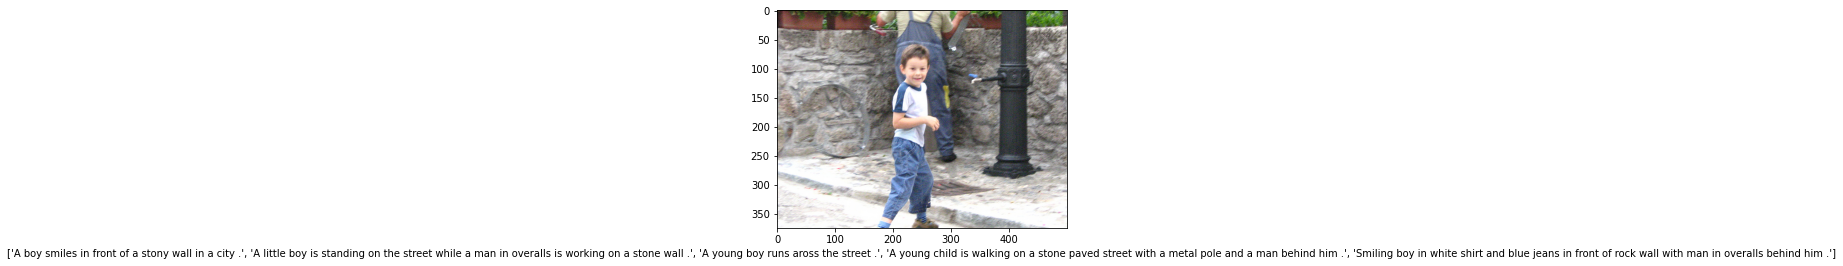

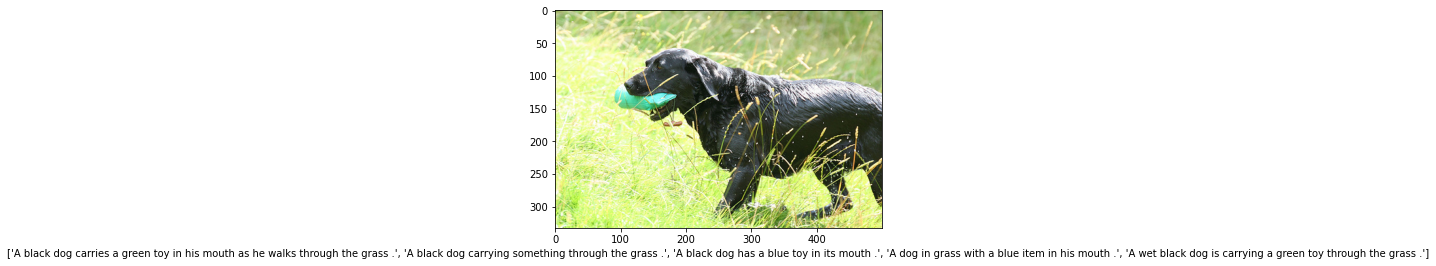

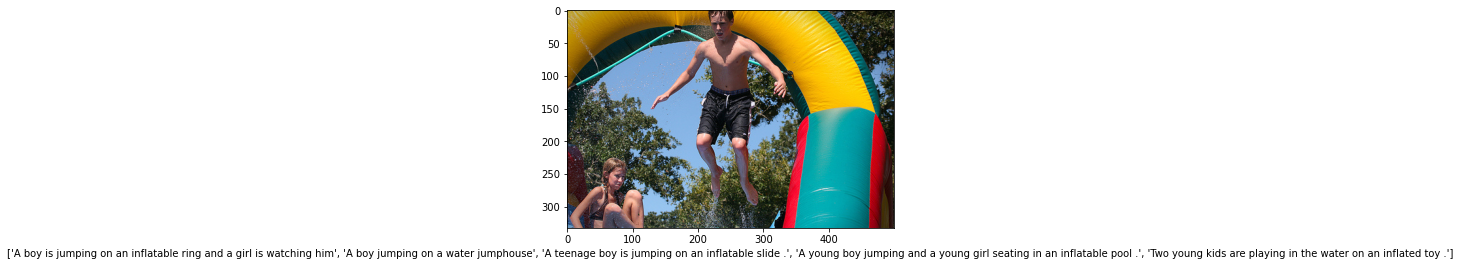

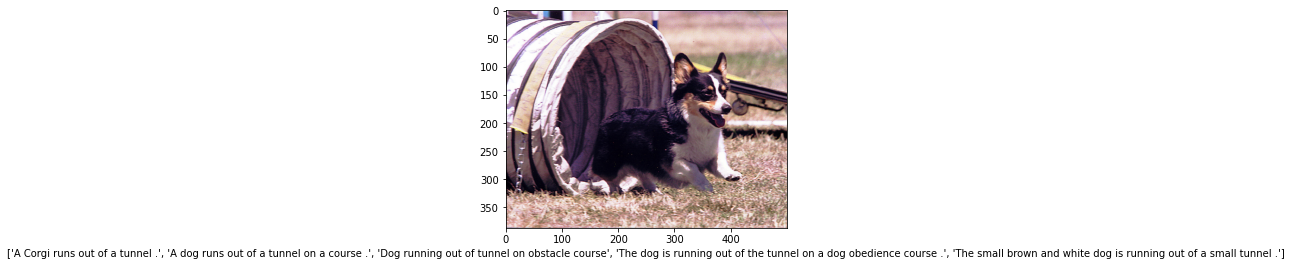

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
  plt.figure()
  img_name = images[i]
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.xlabel(captions_dict[img_name.split('/')[-1]])
  plt.imshow(img)

## ㅁ. 이미지 & 캡션 전처리
- 앞의 captions_dict의 dict의 리스트에 든 캡션들 앞뒤로 preprocessed 함수 적용
  - 효과 : 문장앞에 startofseq 놓고 문장뒤에 endofseq 붙이기
  - 예시 : startofseq a dog looks warily at the brown dog investigating his area . endofseq

In [13]:
def preprocessed(txt):
  '''문장앞에 startofseq 놓고 문장뒤에 endofseq 붙이기'''
  modified = txt.lower()
  modified = 'startofseq ' + modified + ' endofseq'
  return modified

In [14]:
# 앞의 captions_dict의 dict의 리스트에 든 캡션들 앞뒤로 preprocessed 함수 적용
for key, val in captions_dict.items():
  for ele in val:
    captions_dict[key][val.index(ele)] = preprocessed(ele)


In [ ]:
# 예시
captions_dict['2276499757_b44dc6f8ce.jpg']

['startofseq a dog looks warily at the brown dog investigating his area . endofseq',
 'startofseq a large brown dog is looking at a medium sized black dog . endofseq',
 'startofseq a small black dog looks at a larger brown dog in a grassy field . endofseq',
 'startofseq the big brown dog looks at the small black dog in tall grass . endofseq',
 'startofseq there is a big dog looking at a little dog . endofseq']

## ㅂ. 단어 사전 만들기
- count_words : dict 형태로 key는 단어, value는 단어의 개수, Tokenizer 클래스의 word_counts 속성에 대응
- new_dict :  dict 형태로 key는 단어, value는 단어의 사전번호, Tokenizer 클래스의 word_index 속성에 대응
- captions_dict : 문장의 단어가 모두 수치화된 사전 형태, key는 파일명, value는 Tokenizer 클래스의 texts_to_sequences 속성에 대응
- pad_sequences의 길이는 문장 길이의 최댓값으로 설정(여기서 최댓값이 39에 불과하기 때문에 해도 무방, 다른 데이터셋으로 설정시에 중앙값으로 수정필요

In [ ]:
import nltk
nltk.download('all')

In [15]:
from nltk import word_tokenize
from keras.preprocessing.text import text_to_word_sequence, Tokenizer

sl = []
for key, val in captions_dict.items():
  for ele in val:
    sl.append(ele)
print(len(sl))

7500


In [16]:
tk = Tokenizer(oov_token=1)
tk.fit_on_texts(sl)
print(len(tk.word_index))
print(tk.word_counts)

3886
OrderedDict([('startofseq', 7500), ('a', 11771), ('black', 717), ('horse', 57), ('and', 1612), ('its', 194), ('rider', 34), ('are', 646), ('clearing', 4), ('3', 3), ('rung', 1), ('high', 38), ('jump', 74), ('in', 3596), ('competition', 5), ('endofseq', 7500), ('leap', 5), ('over', 245), ('striped', 37), ('hurdle', 24), ('person', 293), ('is', 1668), ('riding', 156), ('as', 175), ('it', 91), ('jumps', 186), ('an', 469), ('obstacle', 21), ('jumping', 281), ('fence', 43), ('outdoors', 31), ('female', 18), ('athlete', 3), ('into', 224), ('the', 3430), ('sand', 94), ('girl', 697), ('performing', 31), ('long', 64), ('with', 1517), ('arms', 51), ('air', 190), ('woman', 668), ('competing', 5), ('distance', 24), ('while', 343), ('people', 517), ('watch', 42), ('photographed', 2), ('midair', 40), ('softball', 8), ('player', 43), ('pitches', 2), ('ball', 365), ('baseball', 76), ('uniform', 35), ('getting', 20), ('ready', 24), ('to', 637), ('throw', 13), ('at', 531), ('game', 34), ('wearing',

In [17]:
count_words = dict(tk.word_counts)
new_dict = tk.word_index

In [ ]:
# tk.texts_to_sequences
# <OUT> 단어를 new_dict의 마지막 숫자에 대응
# new_dict['<OUT>'] = len(new_dict) 
captions_backup = captions_dict.copy()
captions_dict = captions_backup.copy()

In [ ]:
for key, val in captions_dict.items():
  captions_dict[key] = tk.texts_to_sequences(captions_dict[key])

### pad_sequences 길이는 최대길이로 적용

In [ ]:
# pad_sequences 길이는 최대길이로 적용
MAX_LEN = []
for key, val in captions_dict.items():
  for v in val:
    MAX_LEN.append(len(v))

MAX_LEN = max(MAX_LEN)

In [ ]:
len(new_dict)

3832

In [ ]:
i = 7
to_categorical([captions_dict['2279496715_8ef3ee6edb.jpg'][3][i]], num_classes=VOCAB_SIZE+1)

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
  """caption : dict type """
  n_samples = 0
  x = []
  y_in = []
  y_out = []

  for key, val in caption.items():
    for v in val:
      for i in range(1, len(v)):
        x.append(photo[key])

        in_seq = [v[:i]]
        out_seq = v[i]

        in_seq = pad_sequences(in_seq, maxlen= MAX_LEN, padding='post', truncating='post')[0]
        out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]

        y_in.append(in_seq)
        y_out.append(out_seq)

  return x, y_in, y_out


In [ ]:
x, y_in, y_out = generator(img_feature, captions_dict)
print(len(x), len(y_in), len(y_out))

89498 89498 89498


In [ ]:
x = np.array(x)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')
print(x.shape, y_in.shape, y_out.shape)
# x_의 2번째값은 들어온 벡터 길이 , y_in의 2번째값은 MAX_LEN 과 동일, y_out의 2번째값은 단어사전에 든 단어 수와 동일

(89498, 2048) (89498, 39) (89498, 3833)


In [ ]:
import numpy as np
x = np.load('x.npy')
y_in = np.load('y_in.npy')
y_out = np.load('y_out.npy')

## ㅅ. 모델링

In [ ]:
# from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, \
Activation, RepeatVector,Concatenate

In [ ]:
embedding_size = 128
MAX_LEN = 39
max_len = MAX_LEN
VOCAB_SIZE = 3832
vocab_size = VOCAB_SIZE + 1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])

w = LSTM(128, return_sequences=True)(conca)
w = LSTM(512, return_sequences=False)(w)
w = Dense(vocab_size)(w)
out = Activation('softmax')(w)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 39, 128)          0         
 or)                                                             
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 128)           490624    
                                                                 
 lstm_3 (LSTM)               (None, 39, 256)           394240    
                          

### 모델 형태

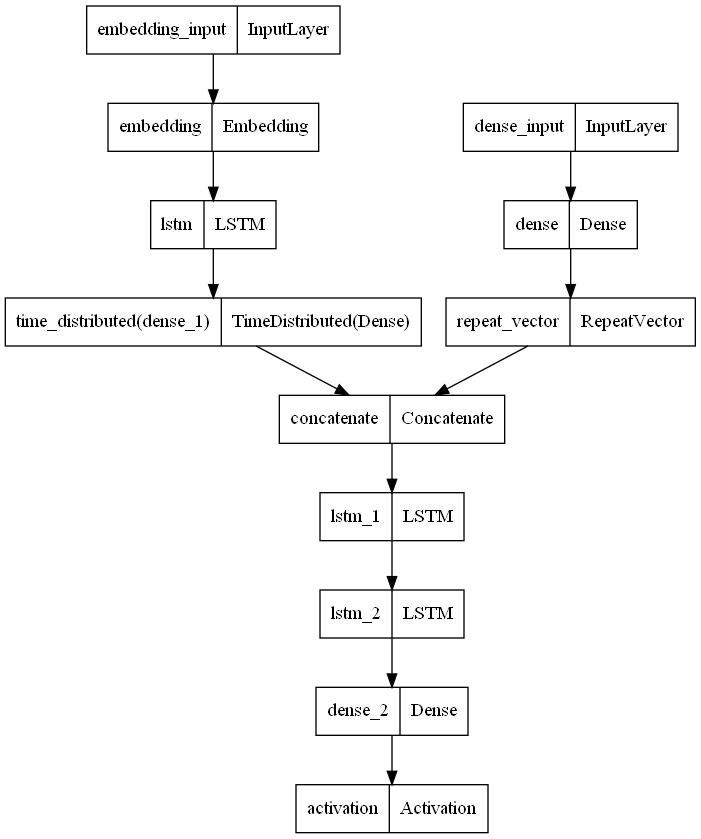

In [ ]:
# 임시 저장
np.save('x.npy', x)
np.save('y_in.npy', y_in)
np.save('y_out.npy', y_out)

In [ ]:
# 모델 피팅
mcp = ModelCheckpoint(filepath='best_model_nlp.h5', monitor='val_loss', save_best_only=True)
history = model.fit([x, y_in], y_out, batch_size=512, epochs=50, callbacks=[mcp])

Epoch 1/50
175/175 [==============================] - ETA: 0s - loss: 5.3474 - accuracy: 0.1284

175/175 [==============================] - 20s 88ms/step - loss: 5.3474 - accuracy: 0.1284
Epoch 2/50
175/175 [==============================] - ETA: 0s - loss: 5.1381 - accuracy: 0.1295

175/175 [==============================] - 16s 91ms/step - loss: 5.1381 - accuracy: 0.1295
Epoch 3/50
175/175 [==============================] - ETA: 0s - loss: 4.9555 - accuracy: 0.1333

175/175 [==============================] - 16s 91ms/step - loss: 4.9555 - accuracy: 0.1333
Epoch 4/50
175/175 [==============================] - ETA: 0s - loss: 4.7460 - accuracy: 0.1576

175/175 [==============================] - 16s 90ms/step - loss: 4.7460 - accuracy: 0.1576
Epoch 5/50
175/175 [==============================] - ETA: 0s - loss: 4.4961 - accuracy: 0.1909

175/175 [==============================] - 15s 89ms/step - loss: 4.4961 - accuracy: 0.1909
Epoch 6/50
175/175 [==============================] - ETA: 0s - loss: 4.3441 - accuracy: 0.2086

175/175 [==============================] - 16s 89ms/step - loss: 4.3441 - accuracy: 0.2086
Epoch 7/50
175/175 [==============================] - ETA: 0s - loss: 4.2281 - accuracy: 0.2212

175/175 [==============================] - 16s 89ms/step - loss: 4.2281 - accuracy: 0.2212
Epoch 8/50
175/175 [==============================] - ETA: 0s - loss: 4.1128 - accuracy: 0.2329

175/175 [==============================] - 16s 90ms/step - loss: 4.1128 - accuracy: 0.2329
Epoch 9/50
175/175 [==============================] - ETA: 0s - loss: 4.0086 - accuracy: 0.2437

175/175 [==============================] - 16s 90ms/step - loss: 4.0086 - accuracy: 0.2437
Epoch 10/50
175/175 [==============================] - ETA: 0s - loss: 3.8565 - accuracy: 0.2602

175/175 [==============================] - 16s 90ms/step - loss: 3.8565 - accuracy: 0.2602
Epoch 11/50
175/175 [==============================] - ETA: 0s - loss: 3.7292 - accuracy: 0.2752

175/175 [==============================] - 16s 90ms/step - loss: 3.7292 - accuracy: 0.2752
Epoch 12/50
175/175 [==============================] - ETA: 0s - loss: 3.5949 - accuracy: 0.2928

175/175 [==============================] - 16s 89ms/step - loss: 3.5949 - accuracy: 0.2928
Epoch 13/50
175/175 [==============================] - ETA: 0s - loss: 3.4632 - accuracy: 0.3121

175/175 [==============================] - 16s 90ms/step - loss: 3.4632 - accuracy: 0.3121
Epoch 14/50
175/175 [==============================] - ETA: 0s - loss: 3.3435 - accuracy: 0.3259

175/175 [==============================] - 16s 90ms/step - loss: 3.3435 - accuracy: 0.3259
Epoch 15/50
175/175 [==============================] - ETA: 0s - loss: 3.2327 - accuracy: 0.3414

175/175 [==============================] - 16s 90ms/step - loss: 3.2327 - accuracy: 0.3414
Epoch 16/50
175/175 [==============================] - ETA: 0s - loss: 3.1179 - accuracy: 0.3568

175/175 [==============================] - 16s 90ms/step - loss: 3.1179 - accuracy: 0.3568
Epoch 17/50
175/175 [==============================] - ETA: 0s - loss: 3.0194 - accuracy: 0.3689

175/175 [==============================] - 16s 90ms/step - loss: 3.0194 - accuracy: 0.3689
Epoch 18/50
175/175 [==============================] - ETA: 0s - loss: 2.9255 - accuracy: 0.3839

175/175 [==============================] - 16s 89ms/step - loss: 2.9255 - accuracy: 0.3839
Epoch 19/50
175/175 [==============================] - ETA: 0s - loss: 2.8337 - accuracy: 0.3968

175/175 [==============================] - 16s 89ms/step - loss: 2.8337 - accuracy: 0.3968
Epoch 20/50
175/175 [==============================] - ETA: 0s - loss: 2.7562 - accuracy: 0.4054

175/175 [==============================] - 16s 89ms/step - loss: 2.7562 - accuracy: 0.4054
Epoch 21/50
175/175 [==============================] - ETA: 0s - loss: 2.6731 - accuracy: 0.4190

175/175 [==============================] - 16s 89ms/step - loss: 2.6731 - accuracy: 0.4190
Epoch 22/50
175/175 [==============================] - ETA: 0s - loss: 2.6027 - accuracy: 0.4272

175/175 [==============================] - 16s 89ms/step - loss: 2.6027 - accuracy: 0.4272
Epoch 23/50
175/175 [==============================] - ETA: 0s - loss: 2.5308 - accuracy: 0.4374

175/175 [==============================] - 16s 89ms/step - loss: 2.5308 - accuracy: 0.4374
Epoch 24/50
175/175 [==============================] - ETA: 0s - loss: 2.4654 - accuracy: 0.4477

175/175 [==============================] - 16s 89ms/step - loss: 2.4654 - accuracy: 0.4477
Epoch 25/50
175/175 [==============================] - ETA: 0s - loss: 2.3975 - accuracy: 0.4576

175/175 [==============================] - 16s 89ms/step - loss: 2.3975 - accuracy: 0.4576
Epoch 26/50
175/175 [==============================] - ETA: 0s - loss: 2.3408 - accuracy: 0.4656

175/175 [==============================] - 16s 90ms/step - loss: 2.3408 - accuracy: 0.4656
Epoch 27/50
175/175 [==============================] - ETA: 0s - loss: 2.2772 - accuracy: 0.4750

175/175 [==============================] - 16s 89ms/step - loss: 2.2772 - accuracy: 0.4750
Epoch 28/50
175/175 [==============================] - ETA: 0s - loss: 2.2075 - accuracy: 0.4850

175/175 [==============================] - 16s 89ms/step - loss: 2.2075 - accuracy: 0.4850
Epoch 29/50
175/175 [==============================] - ETA: 0s - loss: 2.1505 - accuracy: 0.4934

175/175 [==============================] - 16s 89ms/step - loss: 2.1505 - accuracy: 0.4934
Epoch 30/50
175/175 [==============================] - ETA: 0s - loss: 2.0913 - accuracy: 0.5008

175/175 [==============================] - 16s 89ms/step - loss: 2.0913 - accuracy: 0.5008
Epoch 31/50
175/175 [==============================] - ETA: 0s - loss: 2.0337 - accuracy: 0.5113

175/175 [==============================] - 16s 90ms/step - loss: 2.0337 - accuracy: 0.5113
Epoch 32/50
175/175 [==============================] - ETA: 0s - loss: 1.9799 - accuracy: 0.5209

175/175 [==============================] - 16s 90ms/step - loss: 1.9799 - accuracy: 0.5209
Epoch 33/50
175/175 [==============================] - ETA: 0s - loss: 1.9306 - accuracy: 0.5294

175/175 [==============================] - 16s 90ms/step - loss: 1.9306 - accuracy: 0.5294
Epoch 34/50
175/175 [==============================] - ETA: 0s - loss: 1.8751 - accuracy: 0.5357

175/175 [==============================] - 16s 89ms/step - loss: 1.8751 - accuracy: 0.5357
Epoch 35/50
175/175 [==============================] - ETA: 0s - loss: 1.8261 - accuracy: 0.5445

175/175 [==============================] - 16s 89ms/step - loss: 1.8261 - accuracy: 0.5445
Epoch 36/50
175/175 [==============================] - ETA: 0s - loss: 1.7720 - accuracy: 0.5532

175/175 [==============================] - 16s 89ms/step - loss: 1.7720 - accuracy: 0.5532
Epoch 37/50
175/175 [==============================] - ETA: 0s - loss: 1.7302 - accuracy: 0.5613

175/175 [==============================] - 16s 90ms/step - loss: 1.7302 - accuracy: 0.5613
Epoch 38/50
175/175 [==============================] - ETA: 0s - loss: 1.6798 - accuracy: 0.5688

175/175 [==============================] - 16s 89ms/step - loss: 1.6798 - accuracy: 0.5688
Epoch 39/50
175/175 [==============================] - ETA: 0s - loss: 1.6322 - accuracy: 0.5782

175/175 [==============================] - 16s 89ms/step - loss: 1.6322 - accuracy: 0.5782
Epoch 40/50
175/175 [==============================] - ETA: 0s - loss: 1.5803 - accuracy: 0.5877

175/175 [==============================] - 16s 90ms/step - loss: 1.5803 - accuracy: 0.5877
Epoch 41/50
175/175 [==============================] - ETA: 0s - loss: 1.5327 - accuracy: 0.5964

175/175 [==============================] - 16s 90ms/step - loss: 1.5327 - accuracy: 0.5964
Epoch 42/50
175/175 [==============================] - ETA: 0s - loss: 1.4965 - accuracy: 0.6044

175/175 [==============================] - 16s 90ms/step - loss: 1.4965 - accuracy: 0.6044
Epoch 43/50
175/175 [==============================] - ETA: 0s - loss: 1.4579 - accuracy: 0.6131

175/175 [==============================] - 16s 89ms/step - loss: 1.4579 - accuracy: 0.6131
Epoch 44/50
175/175 [==============================] - ETA: 0s - loss: 1.4130 - accuracy: 0.6230

175/175 [==============================] - 16s 89ms/step - loss: 1.4130 - accuracy: 0.6230
Epoch 45/50
175/175 [==============================] - ETA: 0s - loss: 1.3741 - accuracy: 0.6314

175/175 [==============================] - 16s 89ms/step - loss: 1.3741 - accuracy: 0.6314
Epoch 46/50
175/175 [==============================] - ETA: 0s - loss: 1.3326 - accuracy: 0.6405

175/175 [==============================] - 16s 89ms/step - loss: 1.3326 - accuracy: 0.6405
Epoch 47/50
175/175 [==============================] - ETA: 0s - loss: 1.3043 - accuracy: 0.6466

175/175 [==============================] - 16s 90ms/step - loss: 1.3043 - accuracy: 0.6466
Epoch 48/50
175/175 [==============================] - ETA: 0s - loss: 1.2631 - accuracy: 0.6552

175/175 [==============================] - 16s 90ms/step - loss: 1.2631 - accuracy: 0.6552
Epoch 49/50
175/175 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.6640

175/175 [==============================] - 16s 89ms/step - loss: 1.2254 - accuracy: 0.6640
Epoch 50/50
175/175 [==============================] - ETA: 0s - loss: 1.1914 - accuracy: 0.6718

175/175 [==============================] - 16s 89ms/step - loss: 1.1914 - accuracy: 0.6718


In [ ]:
# 모델 저장
model.save('model.h5')
model.save_weights('model_weights.h5')

In [ ]:
# np.save('vocab.npy', new_dict)

In [27]:
import pickle
# 딕셔너리 저장
with open('new_dict.pickle','wb') as fw:
    pickle.dump(new_dict, fw)

In [28]:
# 딕셔너리 로딩
with open('new_dict.pickle', 'rb') as fr:
    new_dict = pickle.load(fr)

## ㅇ. 예측

In [18]:
# 모델 로딩
from keras.saving.save import load_model
md = load_model('model.h5')
md

In [19]:
inv_dict = {v:k for k, v in new_dict.items()}

In [20]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

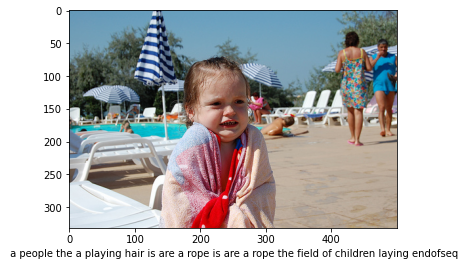

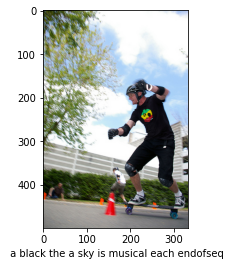

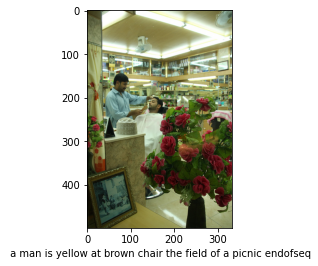

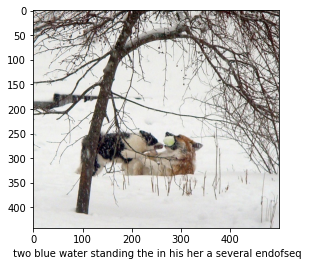

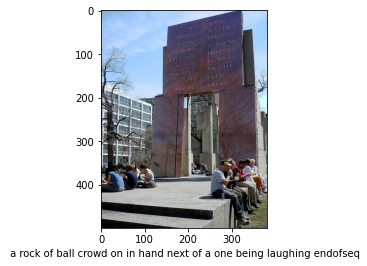

In [21]:
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

MAX_LEN = 39
max_len = MAX_LEN
VOCAB_SIZE = 3832
vocab_size = VOCAB_SIZE + 1


for i in range(5):
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = mde.predict(getImage(no)).reshape(1,2048)
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(md.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

In [23]:
def getImage2(path):
    
    test_img_path = path

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

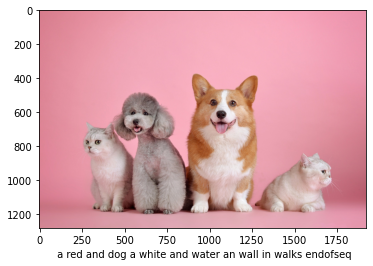

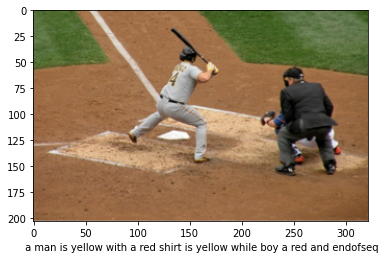

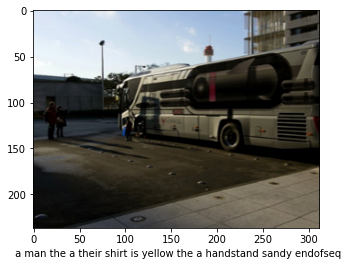

In [26]:
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
def pred_pic(addr):
  MAX_LEN = 39
  max_len = MAX_LEN
  VOCAB_SIZE = 3832
  vocab_size = VOCAB_SIZE + 1
  for i in [addr]:
      test_feature = mde.predict(getImage2(i)).reshape(1,2048)
      test_img_path = i
      test_img = cv2.imread(test_img_path)
      test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

      text_inp = ['startofseq']

      count = 0
      caption = ''
      while count < 25:
          count += 1

          encoded = []
          for i in text_inp:
              encoded.append(new_dict[i])

          encoded = [encoded]

          encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


          prediction = np.argmax(md.predict([test_feature, encoded]))

          sampled_word = inv_dict[prediction]

          caption = caption + ' ' + sampled_word
              
          if sampled_word == 'endofseq':
              break

          text_inp.append(sampled_word)
          
      plt.figure()
      plt.imshow(test_img)
      plt.xlabel(caption)

pred_pic('animal.jpg')
pred_pic('baseball.jpg')
pred_pic('bus.jpg')

## 보완할 점
- 한국어 캡션으로도 만들기
- 성능 개선 (InceptionV3 써보기)
